In [1]:
import yaml as yml
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import mplhep as hep
hep.style.use(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})

In [4]:
from plotting_meta.plotting_meta import cms_format_fig, color_cycle, lumi_dict, BS_BS_y, trident_y, lighten_color
from bff_processor.plotting_utils import color_fader

In [5]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [6]:
fnames = {2016:"samplesCR_2016_Apr2020.yml", 
          2017: "samplesCR_2017_Apr2020.yml",  
          2018:"samplesCR_2018_Apr2020.yml"}
era = '16-18'

#fnames = {2016:"samplesCR_2016_Apr2020.yml"}
#era = '2016'

In [7]:
def make_df(fnames):
    xsec_df = pd.DataFrame()
    for era, fname in fnames.items():
        with open(fname,'r') as f:
            sample_dict = yml.load(f, Loader=yml.FullLoader)
        tdf = pd.DataFrame(sample_dict['samples'])[['name','xsec']]
        tdf['era']  = era
        xsec_df = xsec_df.append(tdf)
    xsec_df.reset_index(inplace=True)
    bff_index = xsec_df.name.map(lambda x: not "BFF" in x)
    xsec_df.drop(xsec_df[bff_index].index, inplace=True)
    return xsec_df
        

In [8]:
xsec_df = make_df(fnames)

In [9]:
def format_dbs(x):
    string = re.findall('dbs(\dp\d+)', x)[0]
    return float('{}.{}'.format(*string.split('p')))

In [10]:
# format dbs gmu mass columns
xsec_df['mass'] = xsec_df.name.map(lambda x:int(re.findall('_M_(\d+)', x)[0]))
xsec_df['dbs'] = xsec_df.name.map(lambda x:format_dbs(x))
xsec_df['gb'] = xsec_df.name.map(lambda x:.02)
xsec_df['gmu'] = xsec_df.name.map(lambda x:.17)
xsec_df['gtau'] = xsec_df.name.map(lambda x:0)

In [11]:
def branching_ratio(x):
    gbgm_ratio = x.gb/x.gmu
    return 2/3*(1 + gbgm_ratio**2 * (1 + 2*x.dbs**2))**-1

def total_xsec(x):
    return x.xsec/branching_ratio(x)

In [12]:
xsec_df['branching_ratio'] = branching_ratio(xsec_df)
xsec_df['total_xsec'] = total_xsec(xsec_df)

In [13]:
# formula to fit for c1 and k per mass point 
def mm_xsec_func(x, c1, k):
    gb = x.gb
    #gb = x.mass**2/(x.gmu*x.dbs)
    return c1 * gb**2 * (1 + k * x.dbs**2) * x.gmu**2
# formula to fit for c1 and k per mass point 
def total_xsec_func(x, c1, k):
    gb = x.gb
    #gb = x.mass**2/(x.gmu*x.dbs)
    return c1 * gb**2 * (1 + k * x.dbs**2) 

In [14]:
def make_x_df(mass, nSamples = 100):
    dbs_gb_df = pd.DataFrame()
    dbs_gb_df['dbs'] = np.linspace(0,1, nSamples)
    dbs_gb_df['gb'] = np.full(nSamples, 0.02)
    dbs_gb_df['gmu'] = np.full(nSamples, 0.17)
    dbs_gb_df['mass'] = np.full(nSamples, mass)
    return dbs_gb_df

/home/ryan/bff_plotting_code_v3/plotting_meta/plotting_meta.py:56: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


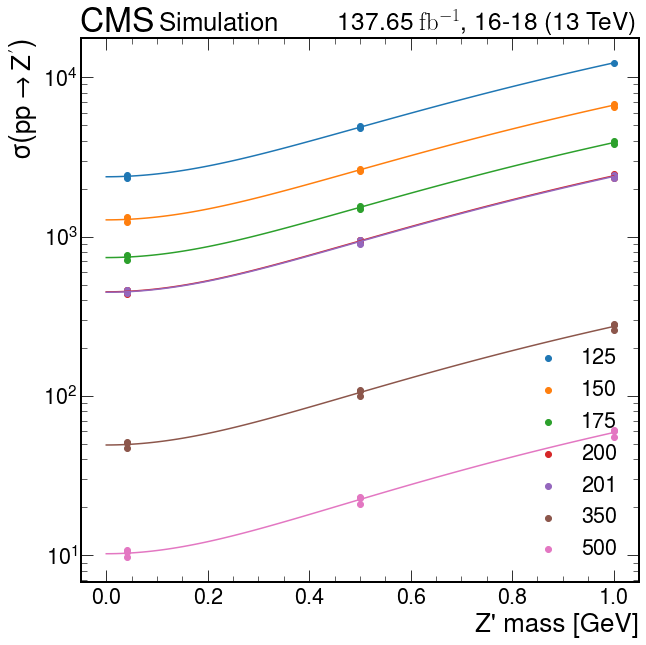

In [15]:
fit_params = []
masses = np.unique(xsec_df.mass)
fig, ax = plt.subplots(figsize=[10,10])
for mass in masses:
    tdf = xsec_df[xsec_df.mass==mass]
    if tdf.shape[0] < 3: continue
    popt, pcov = curve_fit(total_xsec_func, tdf, tdf.total_xsec)
    
    plt.scatter(tdf.dbs, tdf.total_xsec, label=mass)
    dbs_gb_df = make_x_df(mass)
    plt.plot(dbs_gb_df.dbs, total_xsec_func(dbs_gb_df, *popt))
    fit_params.append({"mass": mass, "c1": popt[0], "k": popt[1]})
plt.legend()
plt.yscale('log')
plt.xlabel("Z' mass [GeV]")
plt.ylabel("$ \\sigma \\left( pp\\rightarrow Z'\\right )$")
cms_format_fig(era, ax)
fig.savefig('fits/limit_setting/true_xsec_fit_{}.png'.format(era))

In [16]:
fit_df = pd.DataFrame(fit_params)

In [17]:
from math import e
def power_law(x, c, *params):
    x = x.astype('float')
    y = x*0.
    for i, par in enumerate(params):
        y += np.power(x,i)*par
    return c*np.exp(y)
def linear(x, c1, c2):
    return c1*x + c2
def exponet_500(x,c1,c2,c3,c4,c5,c6,c7):
    #x = x.astype('float')
    x = x/500
    return np.exp(c2*x+c3*x**-1+c4*x**-2+c5*x**-3)*(c1)

In [18]:
masses = np.linspace(125,800,100)
#c1 fit
#popt_c1, pcov_c1 = curve_fit(power_law, fit_df.mass, fit_df.c1, p0=[ 6.13322541e+06,  4.48061026e+00, -4.74447592e-02,  1.03518420e-04, -1.02802728e-07, 0])
popt_c1, pcov_c1 = curve_fit(exponet_500, fit_df.mass, fit_df.c1, p0=[ 1,0,0,0,0,0,0],maxfev=int(2e4))

/home/ryan/Develope/Physics/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 7.06200817e+04 -3.03995349e+00  2.35310307e+00 -3.67400886e-01
  2.58920739e-02  0.00000000e+00  0.00000000e+00] [1.49847680e-03 4.01316039e+00]


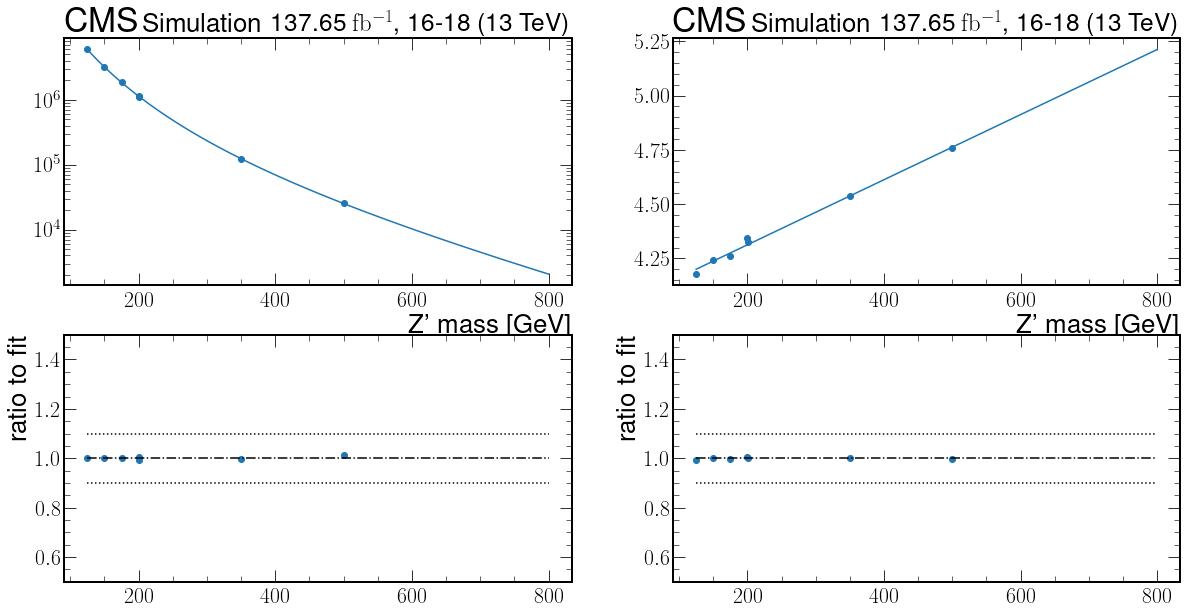

In [19]:
fig, ((left, right), (bl, br)) = plt.subplots(2,2, figsize=[20,10])

def plot_whole_range(ax, val, **kwargs):
    ax.plot((masses[0],masses[-1]),
            (val,val), 
            **kwargs)  
def plot_ratio(ax):
    plot_whole_range(ax, 1, linestyle='-.', color='black')
    plot_whole_range(ax, 1.1, linestyle=':', color='black')
    plot_whole_range(ax, .9, linestyle=':', color='black')
    ax.set_ylim(.5,1.5)
    ax.set_ylabel('ratio to fit')

def compute_c1(x): return exponet_500(x, *popt_c1)
left.plot(masses, compute_c1(masses))
left.scatter(fit_df.mass, fit_df.c1)
left.set_yscale('log')
#ratio
bl.scatter(fit_df.mass, fit_df.c1/compute_c1(fit_df.mass))
plot_ratio(bl)
#k fit
popt_k, pcov_k = curve_fit(linear, fit_df.mass, fit_df.k)
def compute_k(x): return linear(x, *popt_k)
right.plot(masses, compute_k(masses))
right.scatter(fit_df.mass, fit_df.k)
#ratio
br.scatter(fit_df.mass, fit_df.k/compute_k(fit_df.mass))
plot_ratio(br)
left.set_xlabel("Z' mass [GeV]")
right.set_xlabel("Z' mass [GeV]")
cms_format_fig(era, left)
cms_format_fig(era, right)
print(popt_c1, popt_k)

fig.savefig('fits/limit_setting/c1_k_fit_{}.png'.format(era))

In [20]:
def compute_expected_xsec(x):
    mass = x.mass
    c1, k  = compute_c1(mass), compute_k(mass)
    return total_xsec_func(x, c1, k)
xsec_df['comp_total_xsec'] = compute_expected_xsec(xsec_df)
xsec_df['comp_xsec']  = xsec_df['comp_total_xsec']*xsec_df['branching_ratio']

In [21]:
from bff_plotting_tools.data_getter import get_data

In [22]:
sample_dict = {}
for lera in ['2016', '2017', '2018']:
    sample_dict[int(lera)] = get_data(lera)

In [23]:
def compute_weight(row, region, sumw2=False):
    era = row.era
    dbs = row.dbs
    mass = row.mass
    tdf = sample_dict[era][0]
    sample = tdf[(tdf.mass==mass) & (tdf.dbs==dbs) & (tdf[region]==1)]
    if sumw2: return (sample.Weight**2).sum()**.5
    return sample.Weight.sum()
def get_lumi(row):
    era = row.era
    return sample_dict[era][1]

In [24]:
xsec_df['lumi'] = xsec_df.apply(get_lumi, axis=1)
def make_acceptance(reg):
    xsec_df['weight_'+reg] = xsec_df.apply(lambda x: compute_weight(x,reg+"_nom"), axis=1)
    xsec_df['weight_unc_'+reg] = xsec_df.apply(lambda x: compute_weight(x,reg+"_nom",sumw2=True), axis=1)
    xsec_df['acceptance_'+reg] = xsec_df['weight_'+reg]/(xsec_df.xsec*xsec_df.lumi)
    xsec_df['acceptance_unc_'+reg] = xsec_df['weight_unc_'+reg]/(xsec_df.xsec*xsec_df.lumi)
    
make_acceptance('SR1')
make_acceptance('SR2')

In [25]:
def poln(x, *params):
    x = x.astype('float')
    y = x*0.
    for i, par in enumerate(params):
        y += np.power(x,i)*par
    return y

def logisitic(x, c1, c2):
    return 1/(1+10**(-(x-c1)/c2))

def dbs_func(x, c1, c2):
    return c1*(1+c2*x**.5)

def dbs_acceptance_fit(x, c1, c2, c3, c4, c5, *params):
    #y = poln(x.mass, *params)
    y = logisitic(x.mass, *params)
    yp = c3 + c4*y + c5*y**2
    return yp*dbs_func(x.dbs, c1, c2)

In [26]:
def make_mass_x_df(dbs, nSamples = 100):
    dbs_gb_df = pd.DataFrame()
    dbs_gb_df['mass'] = np.linspace(125,500, nSamples)
    dbs_gb_df['dbs'] = np.full(nSamples, dbs)
    return dbs_gb_df

In [88]:
####
## Now, produce era specific plots
####
lera = 2016
era_sel = xsec_df.era==lera
lxsec_df = xsec_df[xsec_df.era==lera]
lera = str(lera)

In [89]:
acceptance_dict = {}
for reg in ['SR1','SR2']:
    tdf = xsec_df[era_sel & (xsec_df.acceptance_SR1 < .2) & (xsec_df.acceptance_SR2 < .1)]
    popt_acc, _ = curve_fit(dbs_acceptance_fit, tdf,tdf['acceptance_{}'.format(reg)], p0=[.1, .3, 0, 1, 0, 180,100], maxfev = int(2e5))
    acceptance_dict[reg] = popt_acc

In [90]:
acceptance_dict

{'SR1': array([ 1.00030128e-01, -3.82596049e-01, -4.83950933e-01,  1.49407687e+00,
         1.33350545e-03,  1.29365756e+02,  7.36709614e+01]),
 'SR2': array([ 2.29230332e-02, -4.21986554e-01, -2.17905526e-01,  1.90851341e+00,
         2.76062667e-07,  1.67425666e+02,  8.90184906e+01])}

In [91]:
def compute_acceptance(x_df, reg):
    popt_acc = acceptance_dict[reg]
    return dbs_acceptance_fit(x_df,*popt_acc)

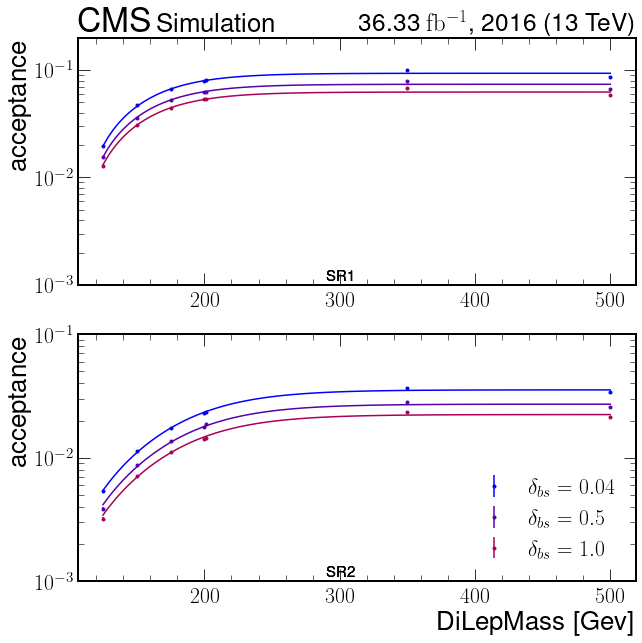

In [92]:
fig, axs = plt.subplots(2,1, figsize=[10,10])
for i, (reg, popt_acc) in enumerate(acceptance_dict.items()):
    ax = axs[i]
    acceptance_string = 'acceptance_{}'.format(reg)
    acceptance_uc_string = 'acceptance_unc_{}'.format(reg)
    colors = [ color_fader('blue', 'red', mix=float(i)/3) for i in range(3)]
    for dbs, c in zip([0.04, 0.5, 1.0],colors):
        tdf = xsec_df[era_sel & (xsec_df.dbs==dbs)]
        x = tdf.mass
        y = tdf[acceptance_string]
        yerr = tdf[acceptance_uc_string]
        x_df = make_mass_x_df(dbs)
        yacc = compute_acceptance(x_df, reg)
        ax.plot(x_df.mass, yacc, color=c)
        ax.errorbar(x,y, yerr=yerr, label='$\delta_{{bs}}={}$'.format(dbs), linestyle='', marker='.', color=c)
        ax.text(290,1.1e-3, reg, fontsize=15) 
        if reg=='SR1':
            ax.set_ylim(1e-3,2e-1)
        else: 
            ax.set_ylim(1e-3,1e-1)
    #plt.yscale('log')
    ax.set_ylabel('acceptance')
    
    ax.set_yscale('log')
axs[1].set_xlabel('DiLepMass [Gev]')
cms_format_fig(lera, axs[0])
plt.legend()
fig.savefig('fits/limit_setting/acceptance_{}.png'.format(lera))

In [93]:
for i, (reg, popt_acc) in enumerate(acceptance_dict.items()):
    acc_string = 'comp_acceptance_{}'.format(reg)
    weight_string = 'comp_weight_{}'.format(reg)
    xsec_df.loc[era_sel, acc_string] = xsec_df[era_sel].apply(lambda x: dbs_acceptance_fit(x,*popt_acc), axis=1)
    xsec_df.loc[era_sel, weight_string] = xsec_df[era_sel][acc_string]*xsec_df.lumi*xsec_df.comp_xsec

/home/ryan/Develope/Physics/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


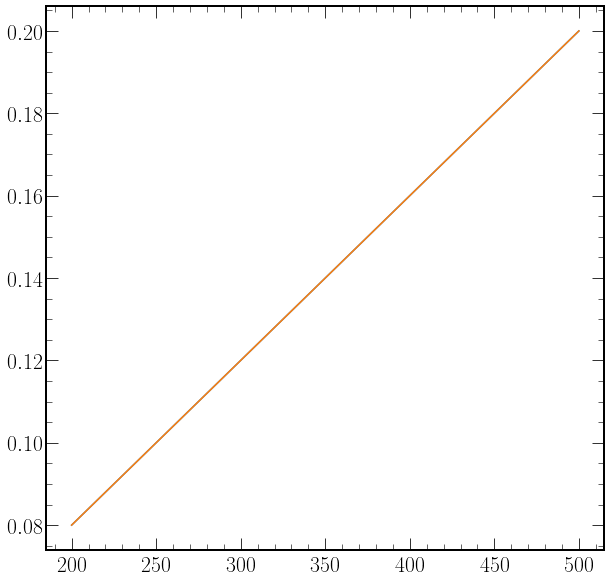

In [94]:
gmu = [0.08, 0.14, 0.20]
mass = np.array([200,350,500])
def linear(x,c1,c2): 
    return x*c1+c2
popt_mass_gmu ,_ = curve_fit(linear, mass, gmu)
plt.plot(mass, gmu)
def mass_to_gmu(x): return linear(x, *popt_mass_gmu)
plt.plot(mass, mass_to_gmu(mass))

In [95]:
def calc_gm(row):
    constant = 1.3*1e-5
    return constant*(row.mass/100)**2/(row.gb*row.dbs)
def calc_gb(row):
    constant = 1.3*1e-5
    return constant*(row.mass/100)**2/(row.gmu*row.dbs)

In [96]:
def compute_xsec(df):
    df['comp_total_xsec'] = compute_expected_xsec(df)
    df['branching_ratio'] = branching_ratio(df)
    df['comp_xsec'] = df['branching_ratio']*df['comp_total_xsec']
    for reg in ['SR1', 'SR2']:
        df['comp_acc_'+reg] = compute_acceptance(df, reg)
        df['comp_xsec_'+reg] = df['comp_xsec']*df['comp_acc_'+reg]
        for era in [2016, 2017, 2018]:
            lumi = lumi_dict[str(era)]
            df['comp_nevt_{}_{}'.format(reg,era)] = df['comp_xsec_'+reg]*lumi
    return df

In [97]:
def make_dbs_mass_df():
    mass = np.array([125,150,175,200,350,500])
    gmu = mass_to_gmu(mass)
    #gb = np.linspace(2e-4, 2e-2, int((2e-2-2e-4)/2e-4+1))
    dbs = np.linspace(1e-2, 1., int((1-1e-2)/(1e-2)+1))
    df =  pd.DataFrame([{"mass": m, "gmu": mass_to_gmu(m), "dbs": d} for m in mass for d in dbs])
    df['gb'] = df.apply(calc_gb, axis=1)
    return compute_xsec(df)
def make_gb_dbs_mass_df():
    mass = np.array([125,150,175,200,350,500])
    gmu = mass_to_gmu(mass)
    gb = np.linspace(2e-4, 2e-2, int((2e-2-2e-4)/2e-4+1))
    dbs = np.linspace(1e-2, 1., int((1-1e-2)/(1e-2)+1))
    df = pd.DataFrame([{"mass": m, "gmu": mass_to_gmu(m),"gb":b, "dbs": d} for m in mass for b in gb for d in dbs])
    return compute_xsec(df)


In [98]:
dbs_mass_df = make_dbs_mass_df()
gb_dbs_mass_df = make_gb_dbs_mass_df()

In [99]:
gb_dbs_mass_df[(gb_dbs_mass_df.mass==125) & 
               (gb_dbs_mass_df.dbs==0.5) & 
              (gb_dbs_mass_df.gb==0.02)][['comp_total_xsec','branching_ratio','gmu','comp_acc_SR1', 'comp_nevt_SR1_2016','comp_nevt_SR2_2016']]

,comp_total_xsec,branching_ratio,gmu,comp_acc_SR1,comp_nevt_SR1_2016,comp_nevt_SR2_2016
9949,4865.979966,0.537634,0.05,0.015505,1473.645384,396.90981


In [100]:
xsec_df[era_sel &
             (xsec_df.mass==125) & 
               (xsec_df.dbs==0.5) & 
              (xsec_df.gb==0.02)][['era','comp_total_xsec','branching_ratio','gmu','comp_acceptance_SR1','comp_weight_SR1','comp_weight_SR2']]

,era,comp_total_xsec,branching_ratio,gmu,comp_acceptance_SR1,comp_weight_SR1,comp_weight_SR2
26,2016,4865.979966,0.653107,0.17,0.015505,1790.15444,482.157965


1.0637732071704982
1.0637732071704984
1.063773207170498
1.0637732071704982
1.0637732071704982
1.063773207170498


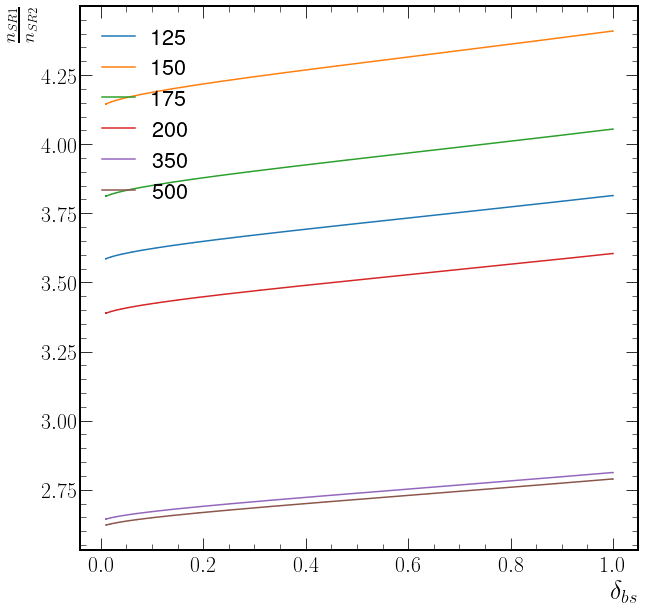

In [101]:
for mass in  [125,150,175,200,350,500]:
    tdf = gb_dbs_mass_df[gb_dbs_mass_df.mass==mass].sort_values(['dbs'])
    y = (tdf['comp_nevt_SR1_2016']/tdf['comp_nevt_SR2_2016']).to_numpy()
    plt.plot(tdf.dbs, y, label=mass)
    print(y[-1]/y[0])
plt.ylabel('$\\frac{n_{SR1}}{n_{SR2}}$')
plt.xlabel('$\delta_{bs}$')
plt.legend()

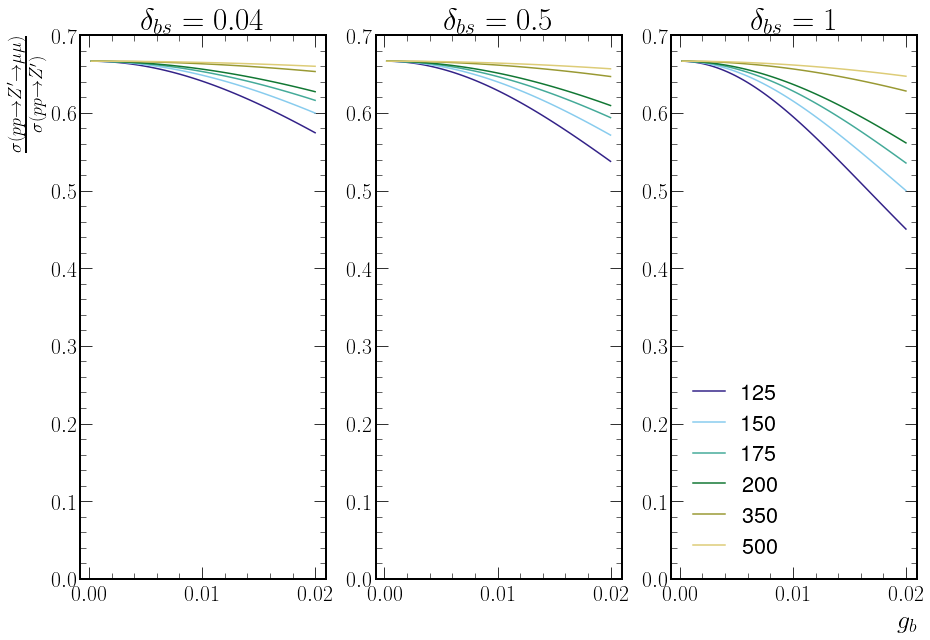

In [102]:
dbss = [.04,.5,1]
fig, axs = plt.subplots(1,len(dbss), figsize=[15,10])
for i, (dbs,ax) in enumerate(zip(dbss,axs)):
    for mass, c in zip([125,150,175,200,350,500],color_cycle):
            tdf = gb_dbs_mass_df[(gb_dbs_mass_df.mass==mass) &  (gb_dbs_mass_df.dbs==dbs)]
            tdf = tdf.sort_values(['gb', 'mass'])
            ax.plot(tdf.gb, tdf.branching_ratio, label=mass, color=c)
            ax.set_title('$\\delta_{{bs}}={}$'.format(dbs))
            ax.set_ylim(0, .7)
plt.legend()
axs[0].set_ylabel("$\\frac{\\sigma \\left( pp\\rightarrow Z'\\rightarrow\\mu\\mu\\right )}{\\sigma \\left( pp\\rightarrow Z'\\right )}$")
axs[2].set_xlabel('$g_b$')
fig.savefig('fits/limit_setting/branching_ratios.png')  


In [103]:
def dbs_mass_nevents_reg_to_gb(df,nevents, reg, lumi):
    acceptance = compute_acceptance(df, reg)
    mm_xsec = nevents/(acceptance*lumi)
    gb = gb_from_mm_xsec_gmu_dbs(mm_xsec,df)
    return gb

In [104]:
def gb_from_mm_xsec_gmu_dbs(mm, df): 
    c1, k = compute_c1(df.mass), compute_k(df.mass)
    noom =  mm
    denom = 2/3*c1*mm*(1+k*df.dbs**2)-2*df.dbs**2 -1
    return noom/denom**.5

In [105]:
def xsec_gmu_dbs_to_gb(x, xsec):
    c1, k = compute_c1(tdf.mass), compute_k(tdf.mass)
    return (xsec/(c1*(1 + k * x.dbs**2) * x.gmu**2))**.5
def total_xsec_gmu_dbs_to_gb(x, xsec):
    c1, k = compute_c1(tdf.mass), compute_k(tdf.mass)
    return (xsec/(c1*(1 + k * x.dbs**2) ))**.5

In [106]:
lim_df = pd.read_csv('limits/limit_{}.csv'.format(lera))
lim_df[lim_df.era==2018]

,Unnamed: 0,16.0,2.5,50.0,84.0,97.5,dbs,era,mass,nJets,sig_type


In [107]:
def make_gb_dbs_df(reg, limit_level):
    selection = lim_df.nJets==reg
    tdf = lim_df[selection]
    gb = dbs_mass_nevents_reg_to_gb(lim_df,lim_df[limit_level], reg, lumi_dict[lera])
    lim_df.loc[selection, "{}_gb".format(limit_level)] = gb

In [108]:
for reg in ['SR1', 'SR2']:
    for level in ['16.0', '2.5', '50.0', '84.0', '97.5']:
        make_gb_dbs_df(reg, level)

In [109]:
lim_count_mean_df = pd.DataFrame()
for reg in ['SR1', 'SR2']:
    for mass in np.unique(lim_df.mass):
        tdf = lim_df[(lim_df.nJets==reg)&
               (lim_df.mass==mass)]
        means = tdf[['mass','16.0', '2.5', '50.0', '84.0', '97.5']].mean(axis=0)
        means['reg'] = reg
        lim_count_mean_df = lim_count_mean_df.append(means,ignore_index=True)

In [110]:
def make_mass_df(mass):
    gmu = mass_to_gmu(mass)
    #gb = np.linspace(2e-4, 2e-2, int((2e-2-2e-4)/2e-4+1))
    dbs = np.linspace(1e-4, 1., int((1-1e-4)/(1e-4)+1))
    df =  pd.DataFrame([{"mass": mass, "gmu": mass_to_gmu(mass), "dbs": d} for d in dbs])
    return df

In [111]:
#sigma[%] = exp[2ln(g_mu) + 1.381] + 0.00038

def width_to_gmu(width):
    return np.exp((np.log(width-0.00038)-1.381)/2)
def curve_of_const_gmu(zmass, gmu):
    dbs = np.linspace(1e-4, 1., int((1-1e-4)/(1e-2)+1))
    constant = 1.3*1e-5
    gb = constant*(zmass/100)**2/(gmu*dbs)
    return gb, dbs

In [112]:
def make_gb_dbs_plot(ax, reg_df,masses=[125,350,500], duplicate=0, postfix = "", single_color="blue"):
    for k, (j, row) in enumerate(reg_df.iterrows()):
        if row.mass not in masses: continue
        dbs_mass_df =  make_mass_df(row.mass)
        def gb_from_lim_level(ll):
            return dbs_mass_nevents_reg_to_gb(dbs_mass_df,row[ll], row.reg, lumi_dict[lera])
        gbs = {ll: gb_from_lim_level(ll) for ll in ['16.0', '2.5', '50.0', '84.0', '97.5']}
        
        color = color_fader('blue', 'red', mix=float(k)/reg_df.shape[0])
        #color = color_fader('blue', 'purple', mix=float(k)/reg_df.shape[0])
        if len(masses)==1: 
            color=single_color
        #if duplicate: color = lighten_color(color, amount=.5)
        if len(masses)==1:
            ax.plot(gbs['50.0'], dbs_mass_df.dbs, label='{} exp. limit'.format(postfix), color=color, zorder=1)
        else: 
            ax.plot(gbs['50.0'], dbs_mass_df.dbs, label='{}{}'.format(int(row.mass), postfix), color=color, zorder=1)
        ax.fill_betweenx( dbs_mass_df.dbs,gbs['16.0'], gbs['84.0'], color=color, alpha=.1, zorder=1)
        #plot data
        def plot_data(dtype, **kwargs):
            tldf = lim_df[(lim_df.mass==row.mass) & (lim_df.nJets==reg)]
            ftldf = tldf[tldf.sig_type==dtype]
            xerror = (ftldf['50.0_gb']-ftldf['16.0_gb'],ftldf['84.0_gb']-ftldf['50.0_gb'])
            ax.errorbar(ftldf['50.0_gb'], ftldf.dbs, xerr = xerror, **kwargs, zorder=1)
        plot_data('fit', color=color,linestyle='', marker='o')
        plot_data('hist', color=color,linestyle='', marker='x')
        if reg=='SR1':
            ax.set_xlim(0,.025)
        else: 
            ax.set_xlim(0,0.02)
        ax.set_ylim(0,1.01)
        if not duplicate: 
            #color="green"
            #draw gmu width curve
            gb, dbs = curve_of_const_gmu(row.mass, width_to_gmu(1))
            ax.plot(gb, dbs, color='black',linestyle='-.', zorder=1, label='width $<$ 1\%')
            #draw BS-BS, neutrino triden
            gb = np.linspace(1e-8, 0.25,1000)
            bsbsy = BS_BS_y(row.mass, gb)
            ty = trident_y(row.mass, gb)
            ax.fill_between(gb,bsbsy,bsbsy+999, color='#c2c2c2', label=r'$B_s-\bar{B_s}$', zorder=0)
            ax.fill_between(gb,ty, color='#ffd7ff', label='$\\nu$ Trident', zorder=0)
    if not duplicate: 
        ax.scatter(-10,-10, marker='o', label='fit', color='black')
        ax.scatter(-10,-10, marker='x', label='hist', color='black')
        #ax.plot(-10,-10, marker='', linestyle='-.', label='width $<$ 1\%', color='black')
        legend_opts = {
            "facecolor": 'white',
            "framealpha": 1,
            "frameon": True
        }
        if len(masses)==1:
            legend_opts["title"] = "$m_{{Z'}} = {}$ GeV".format(masses[0])
        legend = ax.legend( **legend_opts)
        ax.set_xlabel('$g_b$')
        ax.set_ylabel('$\\delta_{bs}$')
    cms_format_fig(str(lera), ax,  data=True, label="Work in Progress")

In [113]:
lim_count_mean_df.loc[lim_count_mean_df.mass==201, "mass"] = 200
dbs_mass_df.loc[dbs_mass_df.mass==201, "mass"] = 200
lim_df.loc[lim_df.mass==201, "mass"] = 200

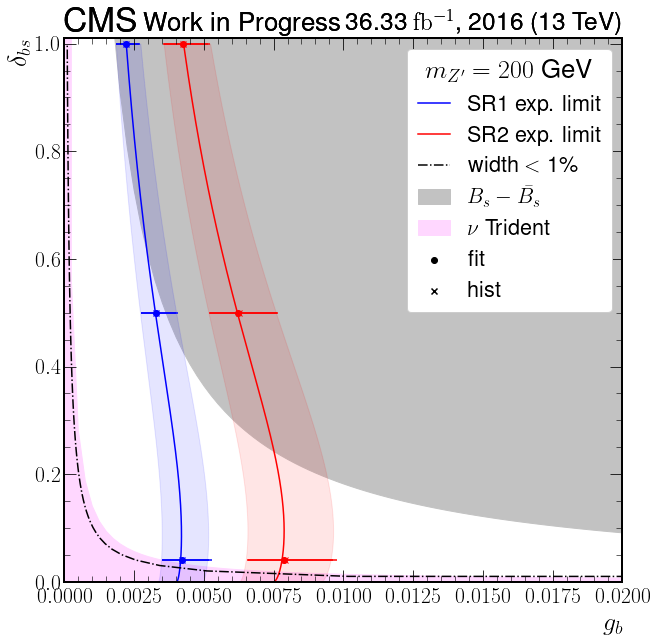

In [114]:
fig, ax = plt.subplots(1,1, figsize=[10,10], frameon=True)
for i, (reg) in enumerate(['SR1', 'SR2']):
    reg_df = lim_count_mean_df[lim_count_mean_df.reg==reg]
    if i == 0:
        make_gb_dbs_plot(ax, reg_df, masses=[200], duplicate=1, postfix=" {}".format(reg))
    else: 
        make_gb_dbs_plot(ax, reg_df, masses=[200], duplicate=0, postfix=" {}".format(reg), single_color="red")
        
fig.savefig('fits/limit_setting/gb_dbs_lim_200_{}.pdf'.format(lera))  

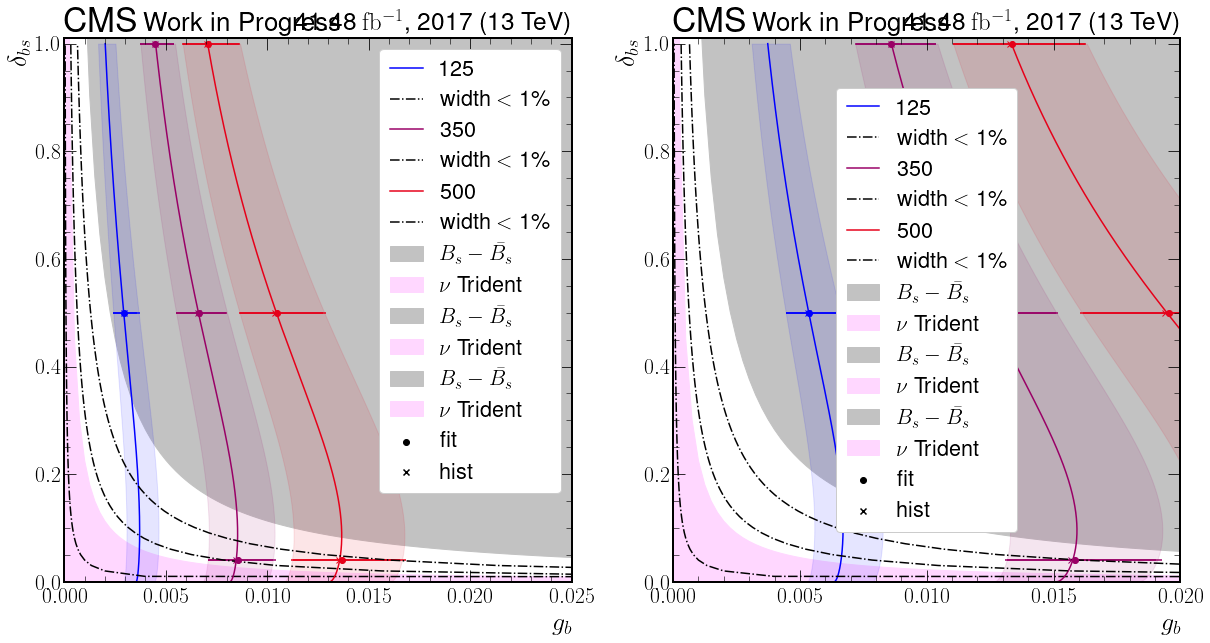

In [83]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
for i, (reg, ax) in enumerate(zip(['SR1', 'SR2'], axs)):
    reg_df = lim_count_mean_df[lim_count_mean_df.reg==reg]
    make_gb_dbs_plot(ax, reg_df)

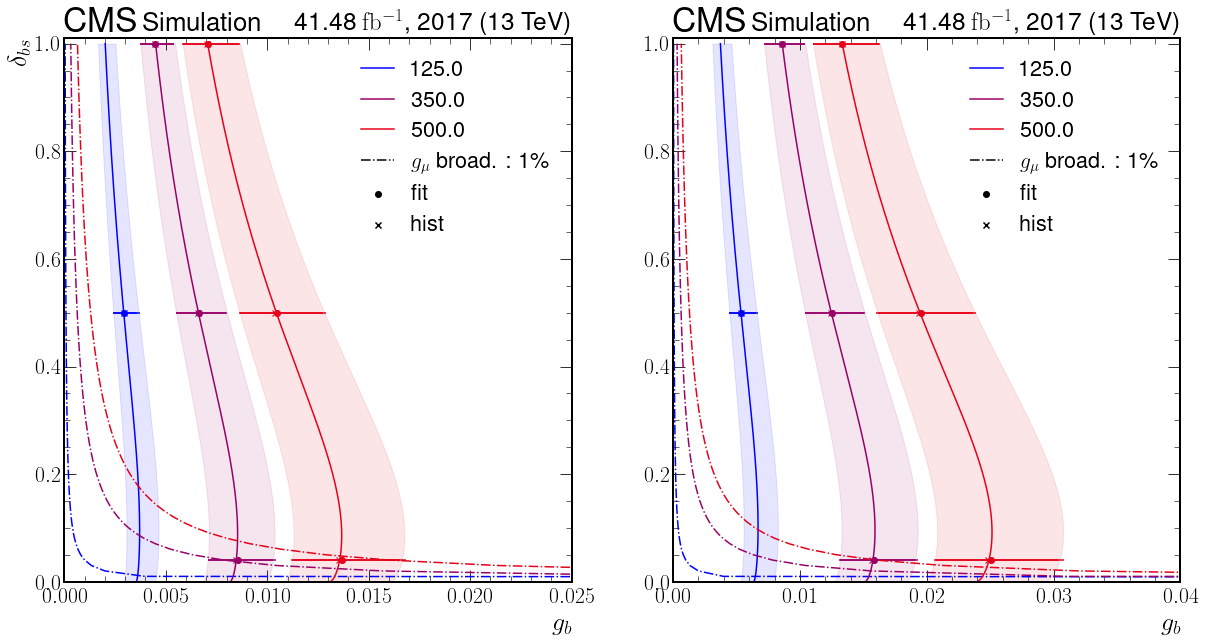

In [84]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
for i, (reg, ax) in enumerate(zip(['SR1', 'SR2'], axs)):
    reg_df = lim_count_mean_df[lim_count_mean_df.reg==reg]
    for k, (j, row) in enumerate(reg_df.iterrows()):
        if row.mass not in [125,350,500]: continue
        dbs_mass_df =  make_mass_df(row.mass)
        def gb_from_lim_level(ll):
            return dbs_mass_nevents_reg_to_gb(dbs_mass_df,row[ll], row.reg, lumi_dict[lera])
        gbs = {ll: gb_from_lim_level(ll) for ll in ['16.0', '2.5', '50.0', '84.0', '97.5']}
        
        color = color_fader('blue', 'red', mix=float(k)/reg_df.shape[0])
        ax.plot(gbs['50.0'], dbs_mass_df.dbs, label='{}'.format(row.mass), color=color)
        ax.fill_betweenx( dbs_mass_df.dbs,gbs['16.0'], gbs['84.0'], color=color, alpha=.1)
        #plot data
        def plot_data(dtype, **kwargs):
            tldf = lim_df[(lim_df.mass==row.mass) & (lim_df.nJets==reg)]
            ftldf = tldf[tldf.sig_type==dtype]
            xerror = (ftldf['50.0_gb']-ftldf['16.0_gb'],ftldf['84.0_gb']-ftldf['50.0_gb'])
            ax.errorbar(ftldf['50.0_gb'], ftldf.dbs, xerr = xerror, **kwargs)
        plot_data('fit', color=color,linestyle='', marker='o')
        plot_data('hist', color=color,linestyle='', marker='x')
        if reg=='SR1':
            ax.set_xlim(0,.025)
        else: 
            ax.set_xlim(0,0.04)
        ax.set_ylim(0,1.01)
        #draw gmu width curve
        gb, dbs = curve_of_const_gmu(row.mass, width_to_gmu(1))
        ax.plot(gb, dbs, color=color,linestyle='-.')
        
    ax.scatter(-10,-10, marker='o', label='fit', color='black')
    ax.scatter(-10,-10, marker='x', label='hist', color='black')
    ax.plot(-10,-10, marker='', linestyle='-.', label='$g_\mu$ broad. : 1\%', color='black')
    ax.legend()
axs[1].set_xlabel('$g_b$')
axs[0].set_xlabel('$g_b$')
axs[0].set_ylabel('$\\delta_{bs}$')
cms_format_fig(str(lera), axs[0])
cms_format_fig(str(lera), axs[1])
fig.savefig('fits/limit_setting/gb_dbs_lim_{}.png'.format(lera))  
